In [18]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from src.model.mask import get_mask_noise
from src.model.dataset import DefaultTransform
from src.model.model import Generator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import torch

In [2]:
tf = DefaultTransform()
device = torch.device('cuda')

In [7]:
images = []
# format: 'data/test/p63/{int}_4_p63.png'
for i in range(0, 3000):
    # check if file exists
    if not os.path.isfile(f'../data/test/p63/{i}_4_p63.png'):
        continue
    try:
        image = Image.open(f'../data/test/p63/{i}_4_p63.png').convert('RGB')
    except:
        continue
    image = tf(image)
    if ((image[1] + image[2]) / 2).mean() >= 0:
        images.append(image.unsqueeze(0).to(device))

In [8]:
len(images)

169

In [10]:
model = torch.load('../data/model_checkpoint_exp_15.pth')
gen = Generator(32, 8).to(device)
gen.load_state_dict(model['generator_he_to_p63_state_dict'])
gen.eval()

Generator(
  (conv1dc): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv1dm): ConvBlock(
    (conv): Conv2d(6, 3, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_1): ConvBlock(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (interpretable_conv_2): ConvBlock(
    (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn)

In [20]:
codes = []
with torch.no_grad():
    for image in images:
        mask = get_mask_noise(image).to(device)
        _ = gen(image, mask)
        code = gen.get_resnet_transformed()
        codes.append(code.detach().cpu().numpy())

In [23]:
codes = np.array(codes).squeeze()

In [25]:
codes_2d = codes.reshape(codes.shape[0], codes.shape[1] * codes.shape[2] * codes.shape[3])

In [26]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(codes_2d)

In [27]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(pca_results)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 169 samples in 0.000s...
[t-SNE] Computed neighbors for 169 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 169 / 169
[t-SNE] Mean sigma: 146.316878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.173489
[t-SNE] KL divergence after 800 iterations: 0.200458


G:\System\Temp\ipykernel_8236\1981288613.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


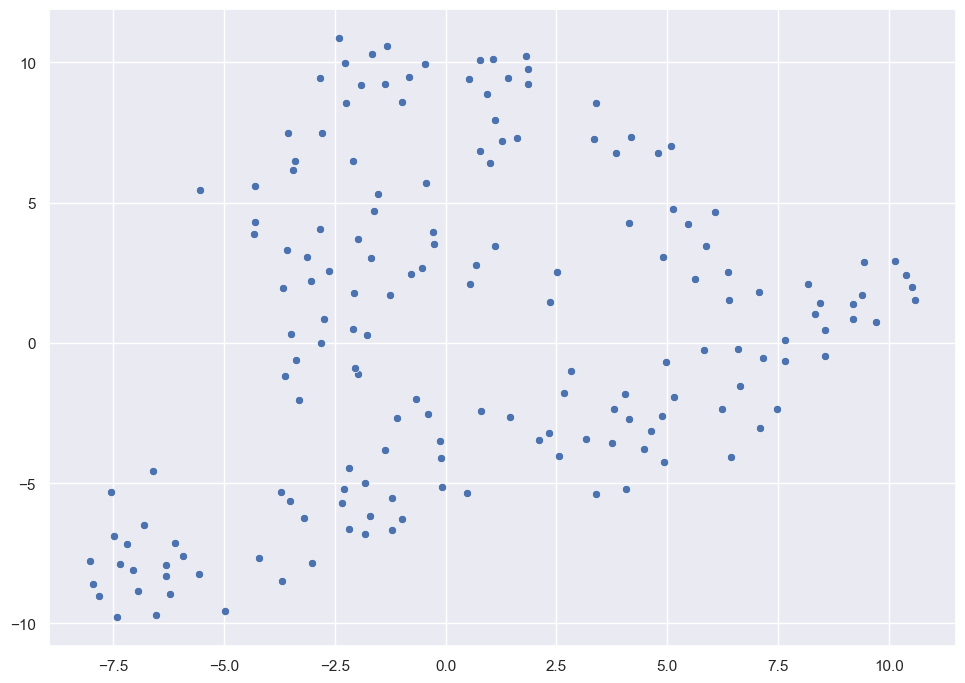

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    palette=palette
)
plt.show()